# Recreated NER twitter classifier

So this is going to be a fresh start, trying to reuse the approach taken by http://didtrumptweetit.com/machine-learning-nltk/, which seems to get 98% accuracy on the same dataset. His model isn't being shared, but he's provided quite a few details. We'll see how far we get.

We'll start by recreating the tfidf-logistic regression model, as although he has mentioned some issues with it, this will be far easy to create than the newer CNN one he created.

## Imports and Configuration

In [26]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams['figure.figsize'] = [10, 6]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data import and preprocessing

We'll be training our model on trump's twitter messages in the range:
- After his campaign anouncement (June 16, 2015)
- Before he became president (January 20, 2017)

We do this because the language use in his tweets is somewhat consistent, even though it changes throughout the campaign. We see a larger divide between his language in this period and the one before his campaign, so we therefore choose to leave those out of the training data.

In [27]:
# Uncomment to get dataset

# ! wget https://raw.githubusercontent.com/bpb27/political_twitter_archive/master/realdonaldtrump/realdonaldtrump.csv -P ../data

In [28]:
twitter_df = (
    pd.read_csv("../data/realdonaldtrump.csv")
    .filter(["created_at", "source", "text", "is_retweet"])
    .assign(created_at=lambda x: pd.to_datetime(x.created_at, format="%a %b %d %H:%M:%S +0000 %Y"))
    .query('created_at > "2015-06-16"')
    .query('created_at < "2017-01-20"')
    .query('is_retweet == False')
    .assign(text=lambda x: x.text.str.replace("&amp;", "&"))
    .drop('is_retweet', axis=1)
    .sort_values("created_at")
)

twitter_df.loc[twitter_df.source != "Twitter for Android", "source"] = "Other Source"
twitter_df.describe()

,created_at,source,text
count,5699,5699,5699
unique,5698,2,5689
top,2016-01-14 05:45:41,Other Source,MAKE AMERICA GREAT AGAIN!
freq,2,3561,9
first,2015-06-16 12:20:40,NaN,NaN
last,2017-01-19 20:21:36,NaN,NaN


In [29]:
print(f"Twitter messages from Trump: {len(twitter_df[twitter_df.source == 'Twitter for Android'])}")
print(f"Twitter messages from other sources: {len(twitter_df[twitter_df.source != 'Twitter for Android'])}")

Twitter messages from Trump: 2138
Twitter messages from other sources: 3561


## Quick exploration of columns

### Sources

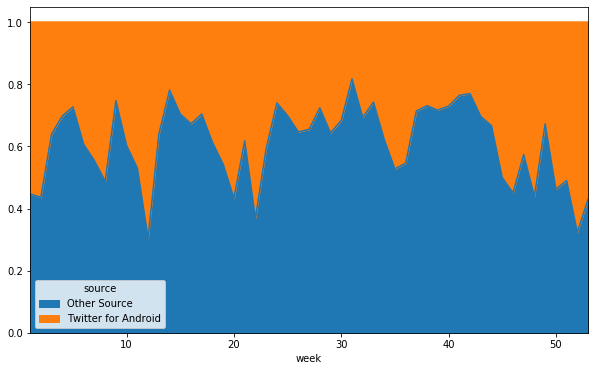

In [30]:
plot_df = (
    twitter_df.assign(week = lambda x: x.created_at.dt.week)
    .groupby(by=["week", "source"])
    .count()
    .reset_index()
    .filter(["week", "source", "text"])
    .pivot("week", "source", "text")
)

plot_df["total"] = plot_df.sum(axis=1)
plot_df["Other Source"] = plot_df["Other Source"]/plot_df["total"]
plot_df["Twitter for Android"] = plot_df["Twitter for Android"]/plot_df["total"]

(
    plot_df.filter(["Other Source", "Twitter for Android"])
    .plot.area()
)

### Twitter Messages

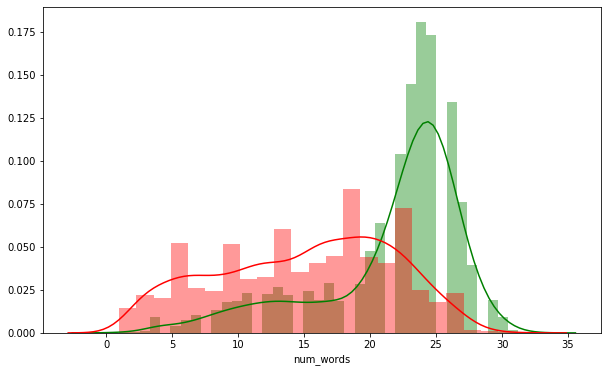

In [31]:
plot_df = (
    twitter_df.filter(["text", "source"])
    .assign(num_words = lambda x: x.text.str.split(" ").apply(len),
            num_char = lambda x: x.text.apply(len),
            num_hashtags = lambda x: x.text.str.findall(r"\@[^\s\,\.\:\!\?]+").apply(len),
            num_mentions = lambda x: x.text.str.findall(r"\#[^\s\,\.\:\!\?]+").apply(len))
)

sns.distplot(plot_df[plot_df["source"] == "Twitter for Android"].num_words, color="g")
sns.distplot(plot_df[plot_df["source"] == "Other Source"].num_words, color="r")

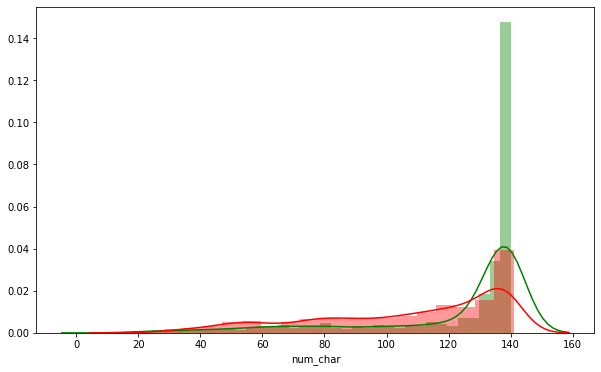

In [32]:
sns.distplot(plot_df[plot_df["source"] == "Twitter for Android"].num_char, color="g")
sns.distplot(plot_df[plot_df["source"] == "Other Source"].num_char, color="r")

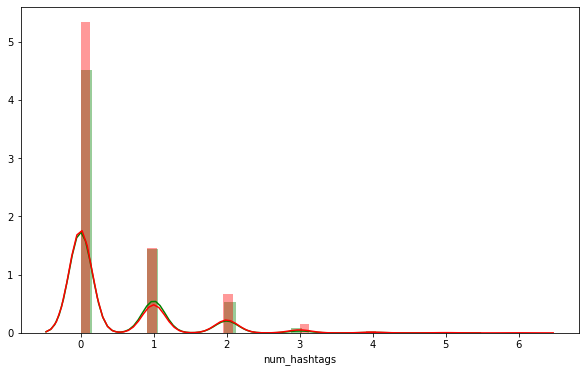

In [33]:
sns.distplot(plot_df[plot_df["source"] == "Twitter for Android"].num_hashtags, color="g")
sns.distplot(plot_df[plot_df["source"] == "Other Source"].num_hashtags, color="r")

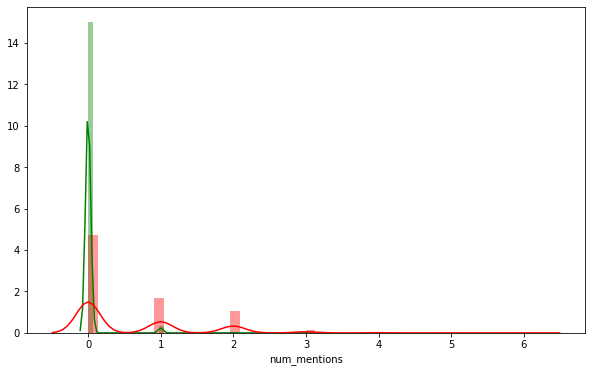

In [34]:
sns.distplot(plot_df[plot_df["source"] == "Twitter for Android"].num_mentions, color="g")
sns.distplot(plot_df[plot_df["source"] == "Other Source"].num_mentions, color="r")

## Exploring NER Taggers

So for this model, instead of using the actual tokens as the input for the model, we'll be using the NER tokens instead. This will give us a representation of how the sentences are structured, instead of just the word use. Essential for this is including bigrams!

For creating these we'll look into using one of nltk/gensim/spacey, as they tend to represent the best/easiest implementations within python

In [35]:
test_messages = twitter_df[twitter_df.source == "Twitter for Android"].text.values.tolist()[:10]
for msg in test_messages:
    print(msg, "\n")

Big time in U.S. today - MAKE AMERICA GREAT AGAIN! Politicians are all talk and no action - they can never bring us back. 

Why did @DanaPerino beg me for a tweet (endorsement) when her book was launched? 

I like Mexico and love the spirit of  Mexican people, but we must protect our borders from people, from all over, pouring into the U.S. 

Mexico is killing the United States economically because their leaders and negotiators are FAR smarter than ours. But nobody beats Trump! 

Druggies, drug dealers, rapists and killers are coming across the southern border. When will the U.S. get smart and stop this travesty? 

My speech is right now on C-SPAN 1 

Thank you @AnnCoulter for your nice words. The U.S. is becoming a dumping ground for the world. Pols don't get it. Make America Great Again! 

Who would you rather have negotiating for the U.S. against Putin, Iran, China, etc., Donald Trump or Hillary? Is there even a little doubt? 

.@KarlRove, who spent $430 million in the last cycle an

### NLTK

`Didtrumptweetit.com` uses the stanford NER tagger from `nltk`, and although it probably works fine, it has an external java dependency which needs to be downloaded seperately. Since the performance difference isn't large, we'll choose for the easier options. 

### Spacy

In [36]:
import spacy
# We'll be using small for testing on our memory starved laptop
nlp = spacy.load('en_core_web_sm')

In [37]:
doc = nlp(test_messages[0])
for token in doc:
    print(f"{token.text:<10} {token.tag_:>10} {spacy.explain(token.tag_)}")

Big                JJ adjective
time               NN noun, singular or mass
in                 IN conjunction, subordinating or preposition
U.S.              NNP noun, proper singular
today              NN noun, singular or mass
-                HYPH punctuation mark, hyphen
MAKE               NN noun, singular or mass
AMERICA            NN noun, singular or mass
GREAT              MD verb, modal auxiliary
AGAIN              RB adverb
!                   . punctuation mark, sentence closer
Politicians        NNS noun, plural
are               VBP verb, non-3rd person singular present
all                DT determiner
talk               NN noun, singular or mass
and                CC conjunction, coordinating
no                 DT determiner
action             NN noun, singular or mass
-                   : punctuation mark, colon or ellipsis
they              PRP pronoun, personal
can                MD verb, modal auxiliary
never              RB adverb
bring              VB verb, base 

In [38]:
doc = nlp(test_messages[1])
for token in doc:
    print(f"{token.text:<10} {token.tag_:>10} {spacy.explain(token.tag_)}")

Why               WRB wh-adverb
did               VBD verb, past tense
@DanaPerino        NNP noun, proper singular
beg                VB verb, base form
me                PRP pronoun, personal
for                IN conjunction, subordinating or preposition
a                  DT determiner
tweet              NN noun, singular or mass
(               -LRB- left round bracket
endorsement         NN noun, singular or mass
)               -RRB- right round bracket
when              WRB wh-adverb
her              PRP$ pronoun, possessive
book               NN noun, singular or mass
was               VBD verb, past tense
launched          VBN verb, past participle
?                   . punctuation mark, sentence closer


In [39]:
doc = nlp(test_messages[4])
for token in doc:
    print(f"{token.text:<10} {token.tag_:>10} {spacy.explain(token.tag_)}")

Druggies          NNS noun, plural
,                   , punctuation mark, comma
drug               NN noun, singular or mass
dealers           NNS noun, plural
,                   , punctuation mark, comma
rapists           NNS noun, plural
and                CC conjunction, coordinating
killers           NNS noun, plural
are               VBP verb, non-3rd person singular present
coming            VBG verb, gerund or present participle
across             IN conjunction, subordinating or preposition
the                DT determiner
southern           JJ adjective
border             NN noun, singular or mass
.                   . punctuation mark, sentence closer
When              WRB wh-adverb
will               MD verb, modal auxiliary
the                DT determiner
U.S.              NNP noun, proper singular
get                VB verb, base form
smart              JJ adjective
and                CC conjunction, coordinating
stop               VB verb, base form
this               

> Awesome, this looks like it's doing exactly what we want, we'll continue our model using this as the input

## Model Definition and Training

We're going to package spacy's POS tagger into an sklearn transformer. We'll also need to speed it up a bit, as it's not the fastest currently.

We've started with disabling the unnecessary model features, but currently the model is running in a parallel fashion either.

### Creating Customer Transformers

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

# We need this for defining TfidfVectorizer such that it can be pickled
def identity(value):
    return value

class NERFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, spacy_model):
        self.spacy_model = spacy_model
        self.nlp = spacy.load(spacy_model, disable=["parser", "ner"])
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return [[token.tag_ for token in doc] for doc in self.nlp.pipe(X)]
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [41]:
def evaluate_model(X_test, y_test, clf, threshold=0.5):
    print(f"Evaluating with threshold: {threshold}")
    y_pred = clf.predict_proba(X_test)[:, 1] > threshold
    # print Accuracy
    print(f"TN: {sum(~y_test & ~y_pred)} FP: {sum(~y_test & y_pred)}")
    print(f"FN: {sum(y_test & ~y_pred)} TP: {sum(y_test & y_pred)}")

    # plot distributions of probabilities
    probs = clf.predict_proba(X_test)[:, 0]
    sns.distplot(probs[y_test == 0], color='g', norm_hist=False, label="true positive")
    sns.distplot(probs[y_test == 1], color='r', norm_hist=False, label="true negative")
    plt.axvline(x=threshold, color="orange")
    plt.xlabel("Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.show()
    
    # Plot ROC curve
    auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    fpr, tpr, threshold = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    plt.plot(fpr,tpr, color="orange", label=f"AUC: {auc:.3f}")
    plt.plot([0,1], [0,1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    maxdiff = np.argmax(tpr - fpr)
    maxdiff_val = threshold[maxdiff]
    plt.plot(threshold, tpr, color="g", label="True Positive Rate")
    plt.plot(threshold, fpr, color="r", label="False Positive Rate")
    plt.plot(threshold, tpr - fpr, color="orange", label="TPR-FPR")
    plt.xlabel("Threshold")
    plt.ylabel("TP/FP Rate")
    plt.xlim(0,1)
    plt.legend()
    plt.show()

In [42]:
# %%timeit -r1
# ner = NERFeatures("en_core_web_lg")
# ner.fit_transform(twitter_df.text)

# "en_core_web_sm" takes 5s for whole corpus, "lg" takes 15

### Splitting into Train/Test

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(twitter_df.drop("source", axis=1), 
                                                    twitter_df.source == "Twitter for Android",
                                                    test_size = 0.1,
                                                    shuffle=False)

print(f"X_train time range: {X_train.created_at.dt.date.min()} to {X_train.created_at.dt.date.max()}")
print(f"X_train time range: {X_test.created_at.dt.date.min()} to {X_test.created_at.dt.date.max()}")

X_train time range: 2015-06-16 to 2016-10-20
X_train time range: 2016-10-20 to 2017-01-19


## Model Training

### Model Creation and Training of Vanilla Model

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

clf = Pipeline([
    ('selector', ColumnSelector('text')),
    ('ner', NERFeatures(spacy_model="en_core_web_sm")),
    ('tfidf', TfidfVectorizer(tokenizer=identity,
                              lowercase=False)),
    ('model', LogisticRegression(solver='lbfgs'))
])

clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('selector', ColumnSelector(key='text')), ('ner', NERFeatures(spacy_model='en_core_web_sm')), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_feat...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

Evaluating with threshold: 0.5
TN: 259 FP: 29
FN: 68 TP: 214


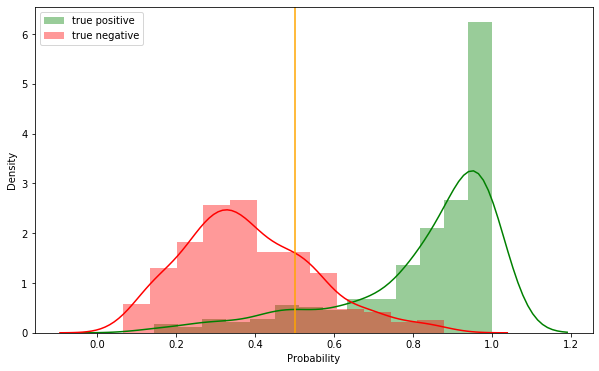

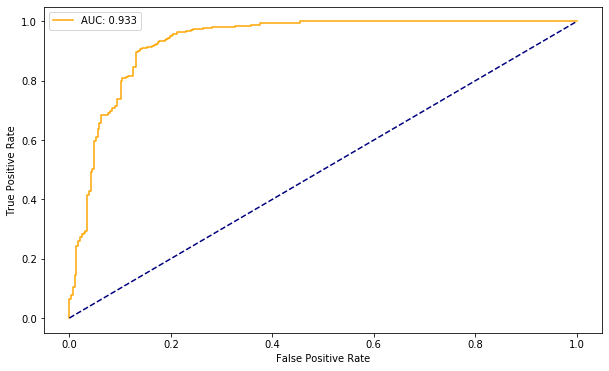

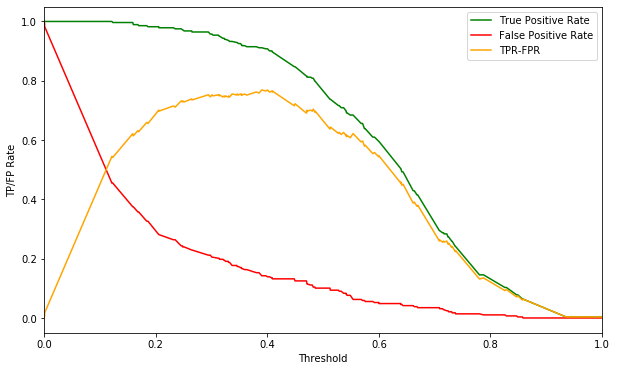

In [45]:
evaluate_model(X_test, y_test, clf)

### Hyperparameter Optimization

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

param_grid = {
    'tfidf__ngram_range': [(1,2), (1,3), (1,4)],
    'model__C': [1, 0.8, 0.6]
}

gs = GridSearchCV(estimator=clf, 
                  param_grid=param_grid,
                  scoring='roc_auc',
                  cv=5,
                  n_jobs=-1,
                  verbose=True)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('selector', ColumnSelector(key='text')), ('ner', NERFeatures(spacy_model='en_core_web_sm')), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_feat...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tfidf__ngram_range': [(1, 2), (1, 3), (1, 4)], 'model__C': [1, 0.8, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [37]:
gs.best_score_

0.8595271355342312

In [33]:
gs.best_params_

{'model__C': 1, 'tfidf__ngram_range': (1, 3)}

## Best Parameters with Large Spacy Model

In [49]:
clf = Pipeline([
    ('selector', ColumnSelector('text')),
    ('ner', NERFeatures(spacy_model="en_core_web_sm")),
    ('tfidf', TfidfVectorizer(tokenizer=identity,
                              lowercase=False,
                              ngram_range=(1,3))),
    ('model', LogisticRegression(solver='lbfgs'))
])

clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('selector', ColumnSelector(key='text')), ('ner', NERFeatures(spacy_model='en_core_web_sm')), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_feat...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

Evaluating with threshold: 0.5
TN: 264 FP: 24
FN: 60 TP: 222


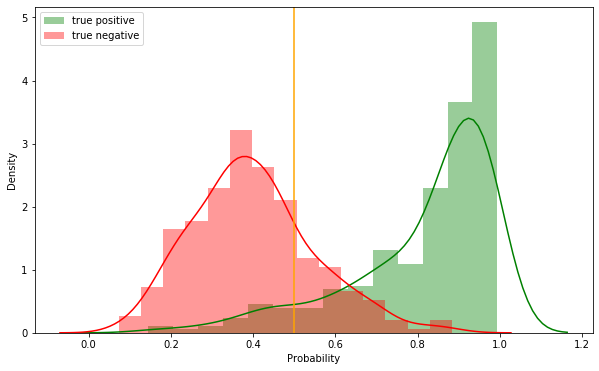

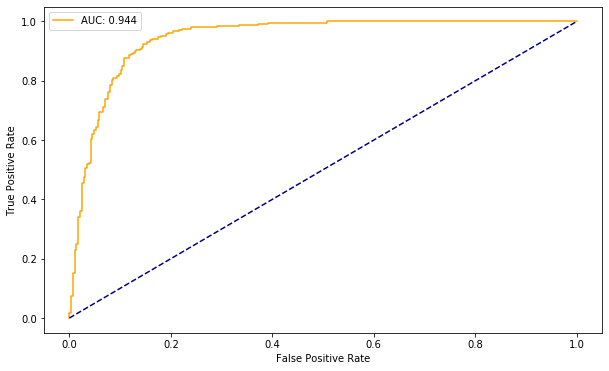

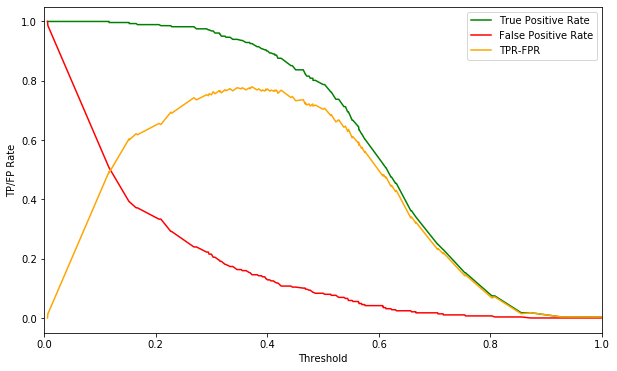

In [50]:
evaluate_model(X_test, y_test, clf)

In [51]:
import joblib

# We needed to pickle en_core_web_sm due to memory issues
joblib.dump(clf, "../models/trump_classifer_095AUC.pkl")

['../models/trump_classifer_095AUC.pkl']

## Evaluating Model Output

In [43]:
for msg in X_test[clf.predict(X_test)].text.tolist()[:10]:
    print(msg, "\n")

Why didn't Hillary Clinton announce that she was inappropriately given the debate questions - she secretly used them! Crooked Hillary. 

The results are in on the final debate and it is almost unanimous, I WON! Thank you, these are very exciting times. 

Great crowd in Johnstown, Pennsylvania- thank you. Get out & VOTE on 11/8! Watch the MOVEMENT in PA. this afternoon… https://t.co/DUMlbSkVeY 

Just returned from Pennsylvania where we will be bringing back their jobs. Amazing crowd. Will be going back tomorrow, to Gettysburg! 

The media refuses to talk about the three new national polls that have me in first place. Biggest crowds ever - watch what happens! 

Well, Iran has done it again. Taken two of our people and asking for a fortune for their release. This doesn't happen if I'm president! 

The attack on Mosul is turning out to be a total disaster. We gave them months of notice. U.S. is looking so dumb. VOTE TRUMP and WIN AGAIN! 

Wow, just came out on secret tape that Crooked Hill

In [44]:
for msg in X_test[~clf.predict(X_test)].text.tolist()[:10]:
    print(msg, "\n")

Totally dishonest Donna Brazile chokes on the truth. Highly illegal! 
Watch: https://t.co/Rs5brj31bA https://t.co/FYoRo6MUjX 

Just landed in Ohio. Thank you America- I am honored to win the final debate for our MOVEMENT. It is time to… https://t.co/ivdjRzL6wZ 

Thank you America! #MAGA

Rasmussen National Poll
Donald Trump 43%
Hillary Clinton 40% https://t.co/n4eZ3qpcjg 

If elected POTUS - I will stop RADICAL ISLAMIC TERRORISM in this country! In order to do this, we need to… https://t.co/45Vyk6z18m 

Thank you Delaware County, Ohio! Remember- either we WIN this election, or we are going to LOSE this country!… https://t.co/ntDRTzYOqi 

Want access to Crooked Hillary? Don't forget - it's going to cost you!
#DrainTheSwamp #PayToPlay https://t.co/qjMBZkEnK9 

On behalf of the entire family, we would truly be honored to have your vote! Let's #MakeAmericaGreatAgain #EarlyVote https://t.co/tv7ihuvmfS 

#ICYMI - OHIO RALLY!
Watch here: https://t.co/0qAjfOcu6Y https://t.co/fpShHiXI31 

UPCOM